<a href="https://colab.research.google.com/github/kimdesok/Introduction-to-TensorFlow-for-Artificial-Intelligence-Machine-Learning-and-Deep-Learning-Coursera/blob/master/C2/C2_W3_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Transfer the learned layers and train the top layers
> 1) just get the convolution layers of one model <br>
> 2) attach some dense layers onto it <br>
> 3) train just the dense network <br>
> 4) evaluate the results <br>
> 5) fine tune by unfreeze a part or whole layers <br>
> 6) re-evaluate

###Prepare the dataset

In [43]:
!wget -q -P /content/ https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip
!wget -q -P /content/ https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip

In [81]:
import zipfile
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

BATCH_SIZE = 32
LOSS_CUT = 0.25
DROP = 0.4
LR = 0.00001
LAYER = 'mixed9'

#Zip file handling
def zip_extract(filename, extract_dir):
  zip_ref = zipfile.ZipFile(filename, 'r')
  zip_ref.extractall(extract_dir)
  zip_ref.close()

#Data generator handling
def gen_dataset(base_dir, dataset_type, labels):
  data_dir = os.path.join(base_dir, dataset_type)
  data_label_dir = [os.path.join(data_dir, label) for label in labels]

  if(dataset_type == 'test'):
    data_datagen = ImageDataGenerator(rescale=1.0/255.)
    return data_datagen

  else:
    data_datagen = ImageDataGenerator(rescale=1./255., 
                                    rotation_range=40,
                                    width_shift_range = 0.2,
                                    height_shift_range =0.2,
                                    shear_range =0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True)
    
    data_generator = data_datagen.flow_from_directory(data_dir, 
                                                      batch_size=BATCH_SIZE, 
                                                      class_mode='binary',
                                                      target_size=(150,150))
    return data_generator, data_label_dir

In [82]:
zip_extract('horse-or-human.zip', '/tmp/train')
zip_extract('validation-horse-or-human.zip', '/tmp/validation')

In [83]:
labels = ['horses', 'humans']

train_generator, train_label_dir = gen_dataset('/tmp', 'train', labels)

validation_generator, validation_label_dir = gen_dataset('/tmp', 'validation', labels)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


Sample horse image:


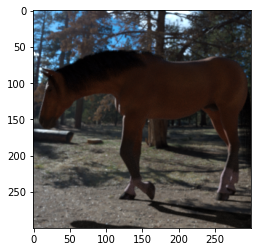


Sample human image:


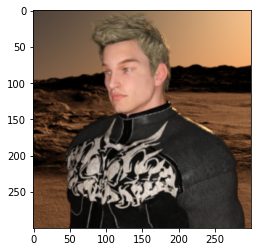

Each image has shape: (300, 300, 3)


In [84]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

print("Sample horse image:")
plt.imshow(load_img(f"{os.path.join(train_label_dir[0],  os.listdir(train_label_dir[0])[0] ) }"))
plt.show()

print("\nSample human image:")
plt.imshow(load_img(f"{os.path.join(train_label_dir[1],  os.listdir(train_label_dir[1])[0] ) }"))
plt.show()

# Load the first example of a horse
sample_image  = load_img(f"{os.path.join(train_label_dir[0], os.listdir(train_label_dir[0])[0])}")

# Convert the image into its numpy array representation
sample_array = img_to_array(sample_image)

print(f"Each image has shape: {sample_array.shape}")

###Setup the pretrained model

In [20]:
#Download the pre-trained weights.  No top means no fully connected dense layer.
!wget --no-check-certificate \
https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
-O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-06-07 06:34:00--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 142.250.107.128, 173.194.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   258MB/s    in 0.3s    

2022-06-07 06:34:00 (258 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [85]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'


def create_pre_trained_model(local_weights_file):

  pre_trained_model = InceptionV3(input_shape =(150,150,3), include_top=False, weights=None)
  pre_trained_model.load_weights(local_weights_file)

#Freeze the weights of the layers
  for layer in pre_trained_model.layers:
    layer.trainable = False
  return pre_trained_model

#Generate an initial model

pre_trained_model = create_pre_trained_model(local_weights_file)

# Print the model summary
#pre_trained_model.summary()


###Callbacks

In [91]:
import tensorflow as tf

# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_loss')<LOSS_CUT):
      print("\nReached validation loss of %.2f so cancelling training!"%LOSS_CUT)
      self.model.stop_training = True

In [87]:
def output_of_last_layer(pre_trained_model):
  last_desired_layer = pre_trained_model.get_layer(LAYER)
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)
  return last_output
  

last_output = output_of_last_layer(pre_trained_model)
print(f'The pretrained model has type: {type(pre_trained_model)}')

last layer output shape:  (None, 3, 3, 2048)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 3, 3, 2048), dtype=tf.float32, name=None), name='mixed9/concat:0', description="created by layer 'mixed9'")
The pretrained model has type: <class 'keras.engine.functional.Functional'>


### Add dense layers for the classifier

In [88]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

def create_final_model(pre_trained_model, last_output):
  #x = layers.Flatten()(last_output)
  x = layers.Dropout(DROP)(last_output)
  x = layers.BatchNormalization()(x)
  x = layers.Dense(8, kernel_regularizer='l1', activation='relu')(x)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(1, activation='sigmoid')(x)

  #Append the dense network to the base model
  model = Model(inputs = pre_trained_model.input, outputs=x)

  #set the training parameters
  model.compile(optimizer = RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy', metrics=['accuracy'])

  return model

model=create_final_model(pre_trained_model, last_output)
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 15,747,313 total parameters in this model.
There are 20,497 trainable parameters in this model.


## Train the model

In [89]:
callbacks = myCallback()

history = model.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 100,
            verbose = 2,
            callbacks=callbacks)

Epoch 1/100
33/33 - 18s - loss: 4.8182 - accuracy: 0.5453 - val_loss: 4.5393 - val_accuracy: 0.7266 - 18s/epoch - 539ms/step
Epoch 2/100
33/33 - 13s - loss: 4.2996 - accuracy: 0.6991 - val_loss: 4.0867 - val_accuracy: 0.9336 - 13s/epoch - 389ms/step
Epoch 3/100
33/33 - 13s - loss: 3.8561 - accuracy: 0.8432 - val_loss: 3.6611 - val_accuracy: 0.9688 - 13s/epoch - 388ms/step
Epoch 4/100
33/33 - 13s - loss: 3.4437 - accuracy: 0.9260 - val_loss: 3.2701 - val_accuracy: 0.9609 - 13s/epoch - 403ms/step
Epoch 5/100
33/33 - 13s - loss: 3.0466 - accuracy: 0.9523 - val_loss: 2.8966 - val_accuracy: 0.9609 - 13s/epoch - 383ms/step
Epoch 6/100
33/33 - 13s - loss: 2.6899 - accuracy: 0.9727 - val_loss: 2.5545 - val_accuracy: 0.9414 - 13s/epoch - 383ms/step
Epoch 7/100
33/33 - 13s - loss: 2.3556 - accuracy: 0.9679 - val_loss: 2.2334 - val_accuracy: 0.9688 - 13s/epoch - 384ms/step
Epoch 8/100
33/33 - 13s - loss: 2.0541 - accuracy: 0.9727 - val_loss: 1.9382 - val_accuracy: 0.9414 - 13s/epoch - 390ms/step


##Evaluate the results

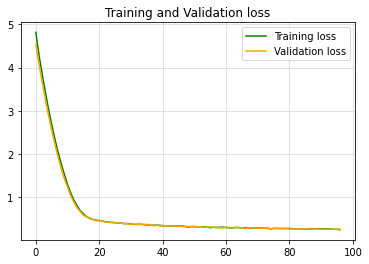

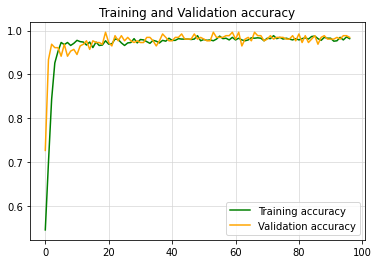

In [90]:
#Plot handling
def plot_results(history, eval_type):
    train_graph = history.history[eval_type]
    validation_graph = history.history['val_'+eval_type]

    epochs = range(len(train_graph))

    plt.plot(epochs, train_graph, 'green', label = 'Training ' + eval_type )
    plt.plot(epochs, validation_graph, 'orange', label = 'Validation ' +eval_type)
    plt.title('Training and Validation ' + eval_type)
    plt.legend(loc=0)
    plt.grid(color='lightgray', alpha = 0.8)

    plt.show()


plot_results(history, 'loss')
plot_results(history, 'accuracy')